In [1]:
import pickle
import torch.nn as nn
import torch.optim as optim
import torch
import numpy as np
import random

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import precision_score, recall_score

from prettytable import PrettyTable

from collections import Counter

from matplotlib import pyplot as plt

In [2]:
with open("data.pkl",'rb') as fp:
    data = pickle.load(fp)


# print(len(data))
# print(train_data[0][0])
# print(test_data[0][0])
print(data[0][0])

print(len(data[1][0]))


[ 0.51851852  0.72        0.21428571  0.43137255  0.25        0.7
  9.          2.         12.          0.47353246  0.46016297  0.44980291
  0.43589744  7.        ]
14


In [3]:
feature_names = ['Vocabulary Knowledge',
                 'Phonological Awareness',
                 'Syntax Awareness',
                 'Working Memory',
                 'Word Reading Fluency',
                 'Word Reading Accuracy',
                 'Sentence Complexity ($\it{M}$)',
                 'Sentence Complexity ($\it{SD}$)',
                 'Sentence Complexity ($\it{max}$)',
                 'Lexical Surprisal ($\it{M}$)',
                 'Lexical Surprisal ($\it{SD}$)',
                 'Lexical Surprisal ($\it{max}$)',
                 'Rare Word Use',
                 'Question Complexity',
                ]
print(len(feature_names))

14


In [9]:
def create_tensors(data_list):
    # create tensor that is compatible to load and train in the language model
    ds = {}
    keys = ['skills','subtests','questions','y','p_index']
    for key in keys:
        ds[key] = []
    
    for entry in data_list:
        ds['skills'].append(entry[0])
        ds['subtests'].append(entry[1])
        ds['questions'].append(entry[2])
        ds['y'].append(entry[3])
        ds['p_index'].append(entry[4])
    
    ds['skills'] = torch.tensor(ds['skills']).type(torch.float)
    ds['subtests'] = torch.tensor(ds['subtests'])
    ds['questions'] = torch.tensor(ds['questions'])
    ds['y'] = torch.tensor(ds['y']).type(torch.float)

    return ds

In [24]:
class BertModel(nn.Module):
    def __init__(self, sentence_dim, skill_dim, dropout):
        super().__init__()
        self.skill_dim = skill_dim
        self.fc_test = nn.Linear(768,sentence_dim)
        self.fc_question = nn.Linear(768,sentence_dim)
        self.fc_answer = nn.Linear(768,sentence_dim)
        self.fc_skill = nn.Linear(skill_dim,skill_dim*2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(2*sentence_dim+skill_dim*2,128)
#         self.fc2 = nn.Linear(sentence_dim+skill_dim*2,128)
        self.out = nn.Linear(128,1)
    
    def forward(self, skills,test,question):
        x1 = self.fc_skill(skills[:,:self.skill_dim])
        x2 = self.fc_test(test)
        x3 = self.fc_question(question)
        x = torch.cat((x1,x2,x3),dim=1)
#         x = torch.cat((x1,x2),dim=1)
        x = self.fc2(self.relu(x))
        pred = self.out(self.relu(x))
        
        return pred

In [19]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [20]:
def confusion_matrix(preds, Y):
    rounded_preds = torch.round(preds.sigmoid())
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    for i, value in enumerate(rounded_preds):
        if value == Y[i] and value == 1:
            TP += 1
        elif value == Y[i] and value == 0:
            TN += 1
        elif value != Y[i] and value == 0:
            FN += 1
        elif value != Y[i] and value == 1:
            FP += 1
        else:
            print(value,Y[i])
    print(f'TP: {TP}\tFN: {FN}')
    print(f'FP: {FP}\tTN: {TN}')

In [21]:

def precision(preds,y):
    rounded_preds = torch.round(preds.sigmoid())
#     print((rounded_preds==1).sum())
#     print((y==1).sum())
    return precision_score(y,rounded_preds)

def recall(preds,y):
    rounded_preds = torch.round(preds.sigmoid())
    return recall_score(y,rounded_preds)
    

In [22]:
def train(model, data, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
        
    optimizer.zero_grad()
    
    predictions = model(data['skills'],data['subtests'],data['questions']).squeeze(1)

    loss = criterion(predictions, data['y'])
    

    acc = binary_accuracy(predictions, data['y'])
    

    loss.backward()

    optimizer.step()

#     epoch_loss += loss.item()
#     epoch_acc += acc.item()
#     print(loss)
#     print(acc)
    return loss,acc 


In [23]:
def evaluate(model, data, criterion, matrix=False):
    
    model.eval()
    
    with torch.no_grad():
        
        predictions = model(data['skills'],data['subtests'],data['questions']).squeeze(1)
        
#         print('eval pred',predictions)

        loss = criterion(predictions, data['y'])
#         print('eval1',data[4])
#         print('eval',(data[4]==0).sum())
        acc = binary_accuracy(predictions, data['y'])
        
        prec = precision(predictions, data['y'])
        
        rec = recall(predictions, data['y'])
        
        if matrix:
            confusion_matrix(predictions, data['y'])
        
#         print(f"Number of positives: {(data[4]==1).sum()}")
#         print(f"Number of negatives: {(data[4]==0).sum()}")

        
    return loss, acc, prec, rec

In [157]:
max_epochs = 300
ep_log_interval = 25
lrn_rate = 0.001
sentence_dim = 64
skill_dim = 14
dropout = 0.1
verbose = False

model_results = []


for i in range(10):
    print(f"Run {i}")
    # Get training and testing data
    train_data, test_data = train_test_split(data, test_size=0.2, random_state = i)
    
    # fix layer initialization
    torch.manual_seed(10)
    net = BertModel(sentence_dim, skill_dim, dropout)
    criterion = nn.BCEWithLogitsLoss() #BCEWithLogitsLoss()
    optimizer = optim.Adam(net.parameters(), lr=lrn_rate)
    train_ds = create_tensors(train_data)
    test_ds = create_tensors(test_data)

    max_stats = [0,0,0,0,0] # each position represents acc, prec, recall, f1, epoch number respectively
    for epoch in range(max_epochs):
        train_loss, train_acc = train(net,train_ds,optimizer,criterion)

        if epoch % ep_log_interval == 0:
            
            valid_loss, valid_acc, prec, rec = evaluate(net,test_ds,criterion,matrix=False)
            if verbose:
                print(f'Epoch: {epoch}')
                print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
                print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
                print('precision: ', prec)
                print('recall: ', rec)
                try:
                    f1 = 2*(prec*rec)/(prec+rec)
                    print(f"f1 = {f1}")
                except:
                    continue
            if valid_acc > max_stats[0]:
                max_stats[0] = float(valid_acc)
                max_stats[1] = prec
                max_stats[2] = rec
                max_stats[4] = epoch
                torch.save(net.state_dict(), 'full.pt')
                # sentence_embedding_model
                
    print(max_stats)        
    model_results.append(max_stats)

print(model_results)

Run 0
[0.7064151167869568, 0.713907284768212, 0.7570224719101124, 0, 250]
Run 1
[0.6830188632011414, 0.689119170984456, 0.7471910112359551, 0, 275]
Run 2
[0.698867917060852, 0.7356164383561644, 0.7227456258411844, 0, 150]
Run 3
[0.702641487121582, 0.7223719676549866, 0.7403314917127072, 0, 150]
Run 4
[0.6867924332618713, 0.6993197278911565, 0.7259887005649718, 0, 250]
Run 5
[0.703396201133728, 0.7206982543640897, 0.7737617135207496, 0, 275]
Run 6
[0.6913207769393921, 0.7049608355091384, 0.7468879668049793, 0, 225]
Run 7
[0.7049056887626648, 0.7365661861074705, 0.7473404255319149, 0, 125]
Run 8
[0.6958490610122681, 0.7098039215686275, 0.75, 0, 200]
Run 9
[0.7162263989448547, 0.7302204928664072, 0.7701778385772914, 0, 175]
[[0.7064151167869568, 0.713907284768212, 0.7570224719101124, 0, 250], [0.6830188632011414, 0.689119170984456, 0.7471910112359551, 0, 275], [0.698867917060852, 0.7356164383561644, 0.7227456258411844, 0, 150], [0.702641487121582, 0.7223719676549866, 0.7403314917127072, 0

In [160]:
new_result = np.asarray(model_results)
print(new_result.shape)
print("mean",np.mean(new_result,axis=0))
print("std",np.std(new_result,axis=0))

(10, 5)
mean [  0.69894339   0.71625843   0.74814472   0.         207.5       ]
std [9.44723587e-03 1.49580989e-02 1.55696205e-02 0.00000000e+00
 5.25000000e+01]


In [93]:
model_1 = BertModel(64, 14, 0.1)
model_1.load_state_dict(torch.load('full.pt'))
print(model_1)

train_data, test_data = train_test_split(data, test_size=0.2, random_state = 40)
test_ds = create_tensors(test_data)

criterion = nn.BCEWithLogitsLoss()
evaluate(model_1,test_ds,criterion,matrix=False)

BertModel(
  (fc_test): Linear(in_features=768, out_features=64, bias=True)
  (fc_question): Linear(in_features=768, out_features=64, bias=True)
  (fc_answer): Linear(in_features=768, out_features=64, bias=True)
  (fc_skill): Linear(in_features=14, out_features=28, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=156, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=1, bias=True)
)


(tensor(0.5809), tensor(0.6989), 0.7018970189701897, 0.7431850789096126)

In [94]:
from captum.attr import IntegratedGradients
ig = IntegratedGradients(model_1)
test_ds['skills'].requires_grad_()
test_ds['subtests'].requires_grad_()
test_ds['questions'].requires_grad_()



attr,delta = ig.attribute((test_ds['skills'],test_ds['subtests'],test_ds['questions'])\
                          ,return_convergence_delta=True)
attr = attr[0].detach().numpy()
print(attr)

[[ 0.34671607 -0.09974326  1.3118764  ... -0.         -0.13181214
  -4.02379686]
 [ 0.2379342  -0.06502189  0.98843849 ... -0.33262415 -0.10106314
  -4.34791352]
 [ 0.20414591 -0.10371971  1.07089025 ... -0.21938969 -0.09363899
  -3.25855563]
 ...
 [ 0.10873534 -0.12871846  1.00325213 ... -0.18126687 -0.07660057
  -2.48843623]
 [ 0.27333609 -0.06086039  1.08306371 ... -0.14106246 -0.085168
  -1.80966607]
 [ 0.10819673 -0.02719603  0.73937561 ... -0.         -0.13470283
  -2.03253953]]


In [92]:
%matplotlib qt 
# attr = attr[0].detach().numpy()
from matplotlib import pyplot as plt

def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
    print(title)
    for i in range(len(feature_names)):
        print(feature_names[i], ": ", '%.3f'%(importances[i]))
    x_pos = (np.arange(len(feature_names)))
    if plot:
        plt.figure(figsize=(12,8))
        plt.bar(x_pos, importances, align='center', color='#DBDBA7')
        plt.xticks(x_pos, feature_names, rotation=45, ha="right", fontsize=19)
        plt.yticks(fontsize=20)
        
        plt.xlabel(axis_title,fontsize=20)
        plt.ylabel('Integrated Gradient',fontsize=20)
#         plt.ylim(-4.5,4.5)
        plt.tight_layout()

#         plt.title(title)
#     plt.show()


In [95]:
visualize_importances(feature_names, np.mean(attr, axis=0))

Average Feature Importances
Vocabulary Knowledge :  0.191
Phonological Awareness :  -0.064
Syntax Awareness :  0.760
Working Memory :  0.776
Word Reading Fluency :  0.041
Word Reading Accuracy :  0.849
Sentence Complexity ($\it{M}$) :  3.964
Sentence Complexity ($\it{SD}$) :  0.722
Sentence Complexity ($\it{max}$) :  -3.751
Lexical Surprisal ($\it{M}$) :  0.076
Lexical Surprisal ($\it{SD}$) :  -0.097
Lexical Surprisal ($\it{max}$) :  -0.176
Rare Word Use :  -0.103
Question Complexity :  -2.676


### Simple NN model without text embeddings

In [66]:
class SimpleNet(nn.Module):
    def __init__(self, skill_dim):
        super().__init__()
        self.fc_skill = nn.Linear(skill_dim,skill_dim*2)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(skill_dim*2,12)
        self.out = nn.Linear(12,1)
        self.skill_dim = skill_dim
        
    def forward(self, skills):
        x1 = self.fc_skill(skills[:,:self.skill_dim])
        x = self.fc2(self.relu(x1))
        pred = self.out(self.relu(x))
        return pred

In [67]:
class SimpleNet_wr(nn.Module): # word rarity model
    def __init__(self, skill_dim):
        super().__init__()
        self.fc_skill = nn.Linear(skill_dim,skill_dim*2)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(skill_dim*2,24)
        self.out = nn.Linear(24,1)
        self.skill_dim = skill_dim
        
    def forward(self, skills):
        x1 = self.fc_skill(skills[:,[0,1,2,3,4,5,6,7,8,13]])
#         x1 = self.fc_skill(skills[:,[0,1,2,3,4,5,9,10,11]])
        x = self.fc2(self.relu(x1))
        pred = self.out(self.relu(x))
        return pred

In [68]:
class SimpleNet_surp(nn.Module): # word surprisal model
    def __init__(self, skill_dim):
        super().__init__()
        self.fc_skill = nn.Linear(skill_dim,skill_dim*2)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(skill_dim*2,24)
        self.out = nn.Linear(24,1)
        self.skill_dim = skill_dim
        
    def forward(self, skills):
#         x1 = self.fc_skill(skills[:,[0,1,2,3,4,5,6,7,8,13]])
        x1 = self.fc_skill(skills[:,[0,1,2,3,4,5,9,10,11]])
        x = self.fc2(self.relu(x1))
        pred = self.out(self.relu(x))
        return pred

In [69]:
def train_simple(model, data, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
        
    optimizer.zero_grad()
    
    predictions = model(data['skills']).squeeze(1)

    loss = criterion(predictions, data['y'])
    

    acc = binary_accuracy(predictions, data['y'])
    

    loss.backward()

    optimizer.step()

#     epoch_loss += loss.item()
#     epoch_acc += acc.item()
#     print(loss)
#     print(acc)
    return loss,acc 

In [70]:
def evaluate_simple(model, data, criterion, matrix=False):
    
    model.eval()
    
    with torch.no_grad():

        predictions = model(data['skills']).squeeze(1)
        
#         print('eval pred',predictions)

        loss = criterion(predictions, data['y'])
#         print('eval1',data[4])
#         print('eval',(data[4]==0).sum())
        acc = binary_accuracy(predictions, data['y'])
        
        prec = precision(predictions, data['y'])
        
        rec = recall(predictions, data['y'])
        
        if matrix:
            confusion_matrix(predictions, data['y'])
        
#         print(f"Number of positives: {(data[4]==1).sum()}")
#         print(f"Number of negatives: {(data[4]==0).sum()}")

        
    return loss, acc, prec, rec

In [90]:
from captum.attr import IntegratedGradients
model = SimpleNet_wr(10)
# model = SimpleNet(6)

model.load_state_dict(torch.load('sentence_complex.pt'))

criterion = nn.BCEWithLogitsLoss()
print(evaluate_simple(model,test_ds,criterion,matrix=False))

ig = IntegratedGradients(model)
test_ds['skills'].requires_grad_()



attr,delta = ig.attribute(test_ds['skills'],return_convergence_delta=True)
attr = attr.detach().numpy()
print(attr)

(tensor(0.6187), tensor(0.6709), 0.6717112922002328, 0.7893296853625171)
[[ 0.20634081  0.66255721  0.49575711 ...  0.          0.
  -0.34858782]
 [ 0.22632155  0.38788487  0.30227968 ...  0.          0.
  -0.47435822]
 [ 0.26722104  0.55789124  0.30414442 ...  0.          0.
  -0.55281681]
 ...
 [ 0.33045997  0.28107825  0.42739872 ...  0.          0.
  -0.33459836]
 [ 0.21858553  0.21510565  0.18361441 ...  0.          0.
  -0.37275225]
 [ 0.28590203  0.59601692  0.42499106 ...  0.          0.
  -0.58321642]]


In [ ]:
SimpleNet_surp

In [81]:
model = SimpleNet_surp(9)
# model = SimpleNet(6)

model.load_state_dict(torch.load('surprisal.pt'))

criterion = nn.BCEWithLogitsLoss()
print(evaluate_simple(model,test_ds,criterion,matrix=False))

ig = IntegratedGradients(model)
test_ds['skills'].requires_grad_()



attr,delta = ig.attribute(test_ds['skills'],return_convergence_delta=True)
attr = attr.detach().numpy()
print(attr)

(tensor(0.5901), tensor(0.6898), 0.694647201946472, 0.7811217510259918)
[[-0.01690678 -0.52970018  1.11474143 ... -0.12971833  0.
   0.        ]
 [-0.01788381 -0.3447793   0.66400647 ... -0.47709763  0.
   0.        ]
 [-0.04691937 -0.45305758  0.5677488  ... -0.49554371  0.
   0.        ]
 ...
 [-0.0599468  -0.20508376  0.91505732 ... -0.12124223  0.
   0.        ]
 [-0.09065155 -0.14235286  0.28001602 ... -0.10747046  0.
   0.        ]
 [ 0.1051948  -0.32046524  0.90409662 ... -0.0961666   0.
   0.        ]]


In [91]:
# visualize_importances(feature_names[:6], np.mean(attr, axis=0)[0,1,2,3,4,5,6,7,8,-1])
indices = [0,1,2,3,4,5,6,7,8,13]#[0,1,2,3,4,5,9,10,11]#[0,1,2,3,4,5,6,7,8,13]
title="Average Feature Importances"
plot=True
axis_title="Features"
new_f_names =[]
importances = np.mean(attr, axis=0)[indices]
for i,name in enumerate(feature_names):
    if i in indices:
        new_f_names.append(name)
        
for i in range(len(new_f_names)):
    print(new_f_names[i], ": ", '%.3f'%(importances[i]))
x_pos = (np.arange(len(new_f_names)))
if plot:
#     plt.figure(figsize=(12,6))
#     plt.bar(x_pos, importances, align='center')
#     plt.xticks(x_pos, new_f_names, rotation='vertical')
#     plt.xlabel(axis_title)
#     plt.ylim(-4.5,4.5)
#     plt.title(title)
    
    plt.figure(figsize=(12,8))
    plt.bar(x_pos, importances, align='center', color='#DBDBA7')
    plt.xticks(x_pos, new_f_names, rotation=45, ha="right", fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel(axis_title,fontsize=20)
    plt.ylabel('Integrated Gradient', fontsize=20)
    plt.ylim(-4.5,4.5)
    plt.tight_layout()
    


Vocabulary Knowledge :  0.223
Phonological Awareness :  0.419
Syntax Awareness :  0.289
Working Memory :  0.304
Word Reading Fluency :  0.184
Word Reading Accuracy :  0.463
Sentence Complexity ($\it{M}$) :  -0.209
Sentence Complexity ($\it{SD}$) :  -0.349
Sentence Complexity ($\it{max}$) :  -0.483
Question Complexity :  -0.499


In [72]:
max_epochs = 300
ep_log_interval = 25
lrn_rate = 0.001
skill_dim = 10
verbose = False

model_results = []


for i in range(10):
    max_stats = [0,0,0,0,0] # each position represents acc, prec, recall, f1, epoch number respectively
    print(f"Run {i}")
    # Get training and testing data
    train_data, test_data = train_test_split(data, test_size=0.2, random_state = i)
    
    # fix layer initialization
    torch.manual_seed(1)
#     net = SimpleNet(skill_dim)
    net = SimpleNet_wr(skill_dim)
    criterion = nn.BCEWithLogitsLoss() #BCEWithLogitsLoss()
    optimizer = optim.Adam(net.parameters(), lr=lrn_rate)
    train_ds = create_tensors(train_data)
    test_ds = create_tensors(test_data)

    
    for epoch in range(max_epochs):
        train_loss, train_acc = train_simple(net,train_ds,optimizer,criterion)

        if epoch % ep_log_interval == 0:
            
            valid_loss, valid_acc, prec, rec = evaluate_simple(net,test_ds,criterion,matrix=False)
            if verbose:
                print(f'Epoch: {epoch}')
                print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
                print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
                print('precision: ', prec)
                print('recall: ', rec)
                try:
                    f1 = 2*(prec*rec)/(prec+rec)
                    print(f"f1 = {f1}")
                except:
                    continue
            if valid_acc > max_stats[0]:
                max_stats[0] = float(valid_acc)
                max_stats[1] = prec
                max_stats[2] = rec
                max_stats[4] = epoch
                torch.save(net.state_dict(), 'sentence_complex.pt')
                
    print(max_stats)        
    model_results.append(max_stats)




Run 0
[0.652075469493866, 0.6467836257309941, 0.776685393258427, 0, 250]
Run 1
[0.6671698093414307, 0.6630565583634176, 0.773876404494382, 0, 275]
Run 2
[0.6686792373657227, 0.6844660194174758, 0.7590847913862718, 0, 250]
Run 3
[0.6649056673049927, 0.6707317073170732, 0.7596685082872928, 0, 275]
Run 4
[0.6437735557556152, 0.6460396039603961, 0.7372881355932204, 0, 275]
Run 5
[0.6709433794021606, 0.681024447031432, 0.7831325301204819, 0, 250]
Run 6
[0.653584897518158, 0.6556603773584906, 0.7690179806362379, 0, 275]
Run 7
[0.6694339513778687, 0.682983682983683, 0.7792553191489362, 0, 275]
Run 8
[0.6686792373657227, 0.6727272727272727, 0.7665745856353591, 0, 250]
Run 9
[0.6709433794021606, 0.6717112922002328, 0.7893296853625171, 0, 250]


In [26]:
new_result = np.asarray(model_results)
print(new_result.shape)
print("mean",np.mean(new_result,axis=0))
print("std",np.std(new_result,axis=0))

(10, 5)
mean [  0.67524529   0.68394467   0.75939413   0.         235.        ]
std [8.26786839e-03 1.23020716e-02 1.54307454e-02 0.00000000e+00
 2.29128785e+01]


In [109]:
new_result = np.asarray(model_results)
print(new_result.shape)
print("mean",np.mean(new_result,axis=0))
print("std",np.std(new_result,axis=0))

(10, 5)
mean [  0.67667924   0.68362236   0.76535506   0.         210.        ]
std [8.87362400e-03 1.20271144e-02 1.59176440e-02 0.00000000e+00
 4.21307489e+01]


## Error analysis

In [34]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state = 4)
test_ds = create_tensors(test_data)
model_2 = SimpleNet(6)
model_2.load_state_dict(torch.load('basemodel_full.pt'))
evaluate_simple(model_2,test_ds,criterion,matrix=False)


(tensor(0.7138), tensor(0.4657), 0.0, 0.0)

In [35]:
def McNemar_test(pred_1,pred_2,y):
    rounded_preds_1 = torch.round(torch.sigmoid(pred_1))
    correct_1 = rounded_preds_1 == y
    
    rounded_preds_2 = torch.round(torch.sigmoid(pred_2))
    correct_2 = rounded_preds_2 == y
    
    tl = 0
    tr = 0
    bl = 0
    br = 0
    
    a = []
    b = []
    c = []
    d = []
    
    for i in range(len(correct_1)):
        if correct_1[i] == 1 and correct_2[i] == 1:
            tl += 1
            a.append(i)
        elif correct_1[i] == 1 and correct_2[i] == 0:
            tr += 1
            b.append(i)
        elif correct_1[i] == 0 and correct_2[i] == 1:
            bl += 1
            c.append(i)
        elif correct_1[i] == 0 and correct_2[i] == 0:
            br += 1
            d.append(i)
        else:
            print('Unexpected value in counting correctness',correct_1[i],correct_2[i])
    
    t = PrettyTable(['', 'Model 2 Correct', 'Model 2 Wrong'])
    t.add_row(['Model 1 Correct', tl, tr])
    t.add_row(['Model 1 Wrong', bl, br])
    print(t)
    return tr,bl, [a,b,c,d]

In [166]:
from scipy.stats.distributions import chi2
# model_1 = SimpleNet_wr(7)
# model_1.load_state_dict(torch.load('vocab_rare.pt'))
# model_1 = SimpleNet_surp(9)
# model_1.load_state_dict(torch.load('surprisal.pt'))
model_1 = BertModel(64,14,0.2)
model_1.load_state_dict(torch.load('full.pt'))
# model_1 = BertModel(64,6,0.2)
# model_1.load_state_dict(torch.load('sentence_embed.pt'))
model_2 = SimpleNet(6)
model_2.load_state_dict(torch.load('basemodel.pt'))
# model_2 = BertModel(64,6,0.2)
# model_2.load_state_dict(torch.load('sentence_embed.pt'))

with open("data.pkl",'rb') as fp:
    data = pickle.load(fp)
train_data, test_data = train_test_split(data, test_size=0.2, random_state = 4)
test_ds = create_tensors(test_data)



model_1.eval()
model_2.eval()
pred_1 = model_1(test_ds['skills'],test_ds['subtests'],test_ds['questions']).squeeze(1)
# pred_1 = model_1(test_ds['skills']).squeeze(1)

pred_2 = model_2(test_ds['skills']).squeeze(1)
# pred_2 = model_2(test_ds['skills'],test_ds['subtests'],test_ds['questions']).squeeze(1)

b,c,index_table = McNemar_test(pred_1,pred_2,test_ds['y'])

chi_sq = (abs(b-c)-1)**2
chi_sq = chi_sq/(b+c)

print('McNemar test statistic:', chi_sq)

print('p-value:', chi2.sf(chi_sq, 1))

+-----------------+-----------------+---------------+
|                 | Model 2 Correct | Model 2 Wrong |
+-----------------+-----------------+---------------+
| Model 1 Correct |       784       |      129      |
|  Model 1 Wrong  |        97       |      315      |
+-----------------+-----------------+---------------+
McNemar test statistic: 4.252212389380531
p-value: 0.0391992323727306


torch.Size([129, 14])
[0.45047352 0.6207752  0.51771885 0.45219633 0.46834636 0.73730624]
[0.17011869 0.21154872 0.17429112 0.16020443 0.14309908 0.08779691]


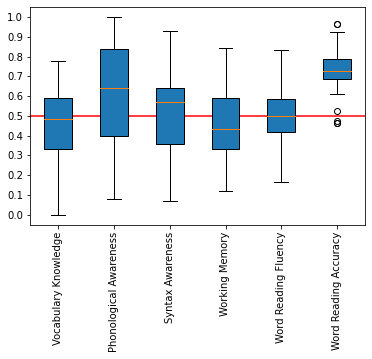

In [96]:
students_skills = test_ds['skills'][index_table[1]]
print(students_skills.shape)
pre_skills = students_skills[:,:6].numpy()
print(np.mean(pre_skills,axis=0))
print(np.std(pre_skills,axis=0))

# for i in range(6):
#     plt.boxplot(pre_skills[:,i])
plt.boxplot(pre_skills, vert=True, patch_artist=True, labels=feature_names[:6])
plt.xticks(rotation='vertical')
plt.yticks(np.arange(0,1.1,0.1))
plt.axhline(y=0.5, color='r', linestyle='-')
plt.show()

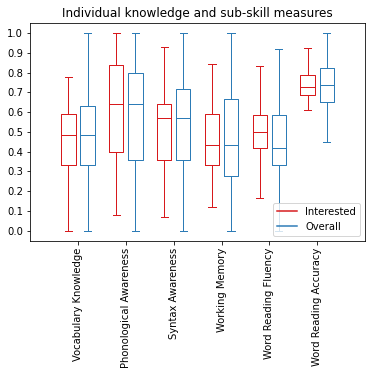

<Figure size 300x2000 with 0 Axes>

In [121]:
data_a = students_skills[:,:6].numpy()
data_b = test_ds['skills'][:,:6].numpy()

ticks = feature_names[:6]

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.figure()

bpl = plt.boxplot(data_a, positions=np.array(range(data_a.shape[1]))*2.0-0.4, sym='', widths=0.6)
bpr = plt.boxplot(data_b, positions=np.array(range(data_b.shape[1]))*2.0+0.4, sym='', widths=0.6)
set_box_color(bpl, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bpr, '#2C7BB6')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='Interested')
plt.plot([], c='#2C7BB6', label='Overall')
plt.legend()

plt.xticks(range(0, len(ticks) * 2, 2), ticks)
plt.xlim(-2, len(ticks)*2)
plt.xticks(rotation='vertical')
plt.yticks(np.arange(0,1.1,0.1))
plt.title("Individual knowledge and sub-skill measures")
plt.figure(figsize=(3, 20),dpi = 100)

# plt.tight_layout()
# plt.savefig('boxcompare.png')
plt.show()

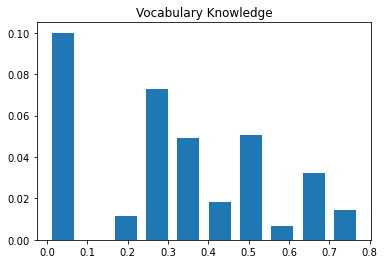

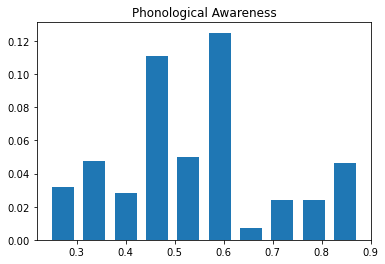

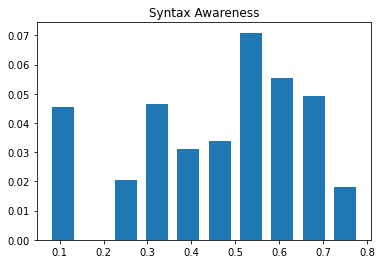

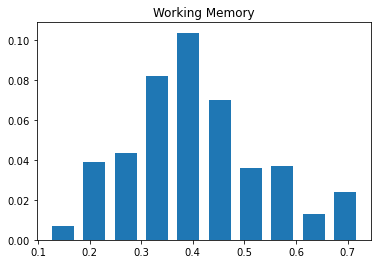

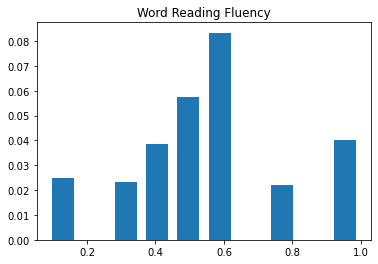

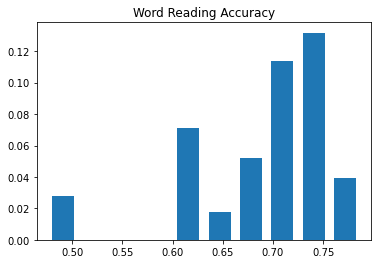

<ipython-input-143-4f97a6b31b97>:27: RuntimeWarning: invalid value encountered in true_divide
  plt.bar(center, hist1/hist2, align='center', width=width)


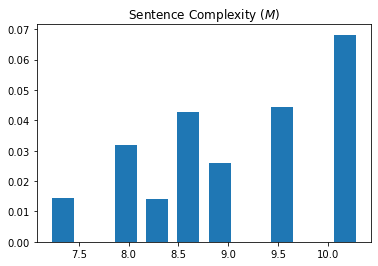

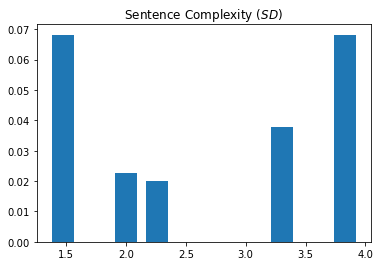

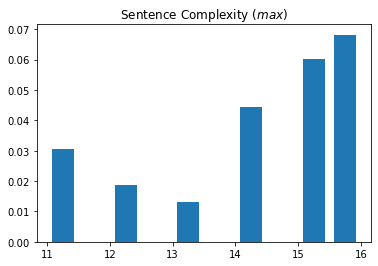

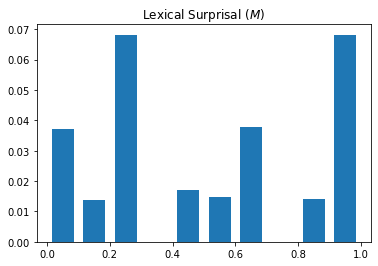

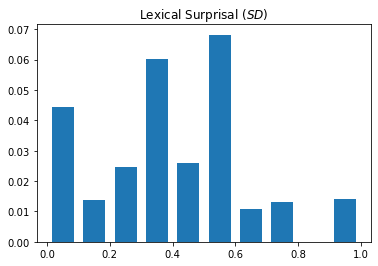

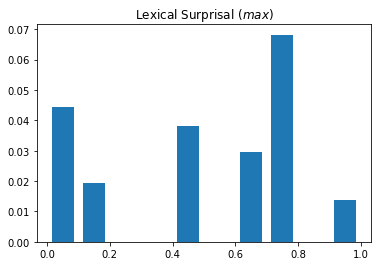

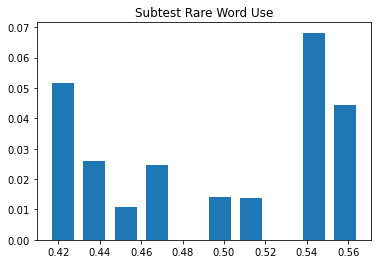

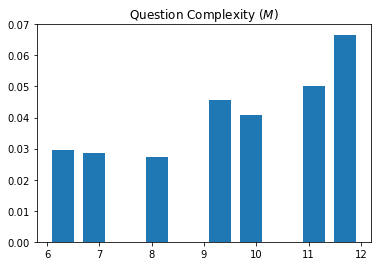

In [143]:
def get_distributions(index_list,dataset,feature_names):
    data_list = []
    dataset = np.asarray(dataset)
    for i in index_list:
        data_list.append(list(dataset[i]))
    data_list = np.asarray(data_list)
    
    for i in range(data_list.shape[1]):
        new_array = data_list[:,i]
#         print(new_array)
#         histo = np.histogram(new_array)
#         print(histo)
#         _ = plt.hist(new_array,range=(dataset[:,i].min(),dataset[:,i].max()))
#         plt.hist(new_array,range=(dataset[:,i].min(),dataset[:,i].max()))
#         plt.ylim(ymax = 350)
#         plt.title(feature_names[i]+ ' (Interested Entries)')
#         plt.show()
#         plt.hist(dataset[:,i],range=(dataset[:,i].min(),dataset[:,i].max()))
#         plt.ylim(ymax = 350)
        
        hist1,bins1 = np.histogram(new_array)

        width = 0.7 * (bins1[1] - bins1[0])
        center = (bins1[:-1] + bins1[1:]) / 2
        
        hist2,bins2 = np.histogram(dataset[:,i],bins = bins1)
        plt.bar(center, hist1/hist2, align='center', width=width)
        plt.title(feature_names[i])
        plt.show()

get_distributions(index_table[1],test_ds['skills'],feature_names)

In [11]:
with open("data.pkl",'rb') as fp:
    data = pickle.load(fp)
train_data, test_data = train_test_split(data, test_size=0.2, random_state = 50)
test_ds = create_tensors(test_data)

In [147]:
# test_model = SimpleNet_wr(7)
# test_model.load_state_dict(torch.load('vocab_rare.pt'))
# model_2 = SimpleNet(6)
# model_2.load_state_dict(torch.load('basemodel.pt'))

# test_model = SimpleNet_surp(9)
# test_model.load_state_dict(torch.load('surprisal.pt'))

# model_1 = BertModel(64,14,0.2)
# model_1.load_state_dict(torch.load('full.pt'))
test_model = BertModel(64,14,0.2)
test_model.load_state_dict(torch.load('full.pt'))

test_model.eval()

pred_1 = test_model(test_ds['skills'],test_ds['subtests'],test_ds['questions']).squeeze(1)
# pred_1 = test_model(test_ds['skills']).squeeze(1)
y = test_ds['y']

rounded_preds_1 = torch.round(torch.sigmoid(pred_1))
correct_1 = rounded_preds_1 == y
err_index = []
for i in range(correct_1.shape[0]):
    if correct_1[i] == False:
        err_index.append(i)
print(correct_1.shape)
print(len(err_index))

torch.Size([1325])
412


0.09740259740259741


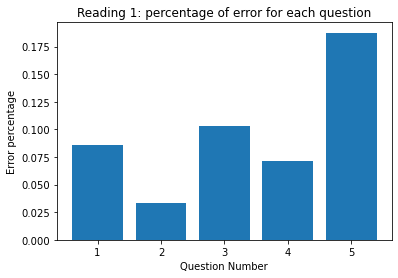

0.08433734939759036


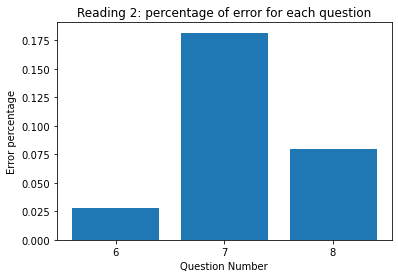

0.07575757575757576


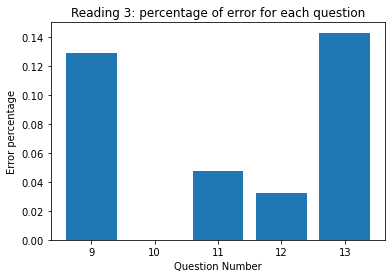

0.0273972602739726


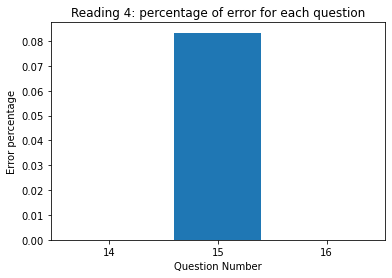

0.07092198581560284


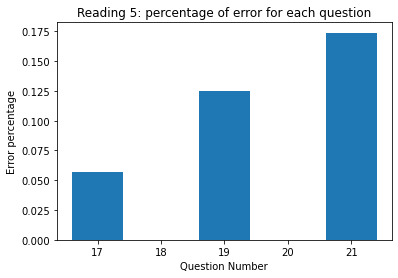

0.07386363636363637


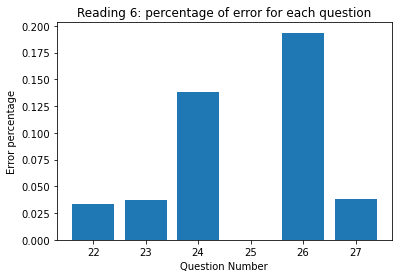

0.06578947368421052


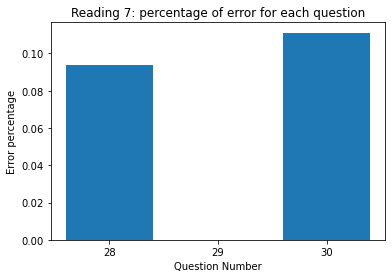

0.044444444444444446


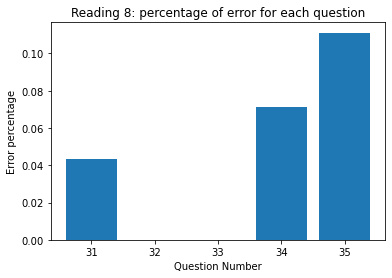

0.050724637681159424


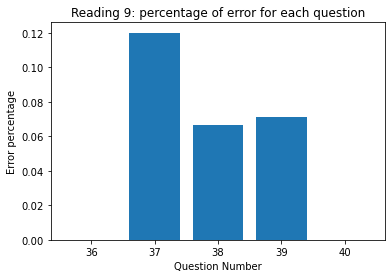

0.06172839506172839


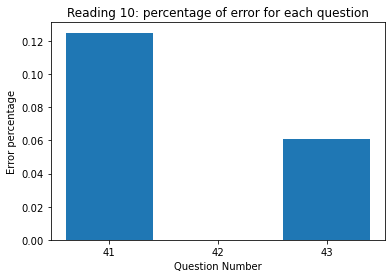

0.125


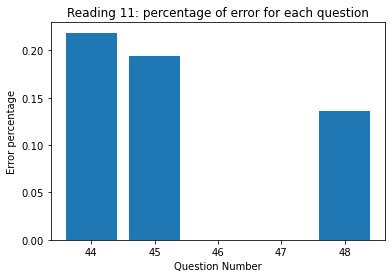

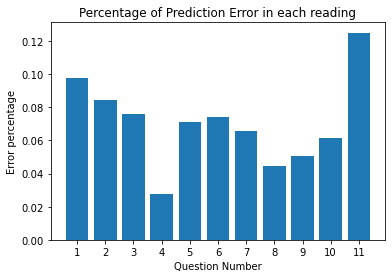

In [167]:
def get_p_distrib(index_list,dataset):
    p_list = []
    dataset = np.asarray(dataset)
    for i in index_list:
        p_list.append(dataset[i])
    p_list = np.asarray(p_list)

#     plt.title('Text-wise Error distribution')
#     plt.xticks(np.arange(0, 10, step=1))
#     plt.show()
    return p_list
    
p_list = get_p_distrib(index_table[2],test_ds['p_index'])
p_overall = np.asarray(test_ds['p_index'])
counter1 = Counter(p_list[:,1])
counter2 = Counter(p_overall[:,1])


questions_ranges = [(1,5), (6,8), (9,13), (14,16), (17,21), (22,27), (28,30),
                   (31,35), (36,40), (41,43), (44,48)]

reading_num = []
reading_error_rate = []
for i in range(len(questions_ranges)):
    x = []
    y = []
    err_total = 0
    p_total = 0
    for j in range(questions_ranges[i][0],questions_ranges[i][1]+1):
        x.append(j)
        y.append(counter1[j]/counter2[j])
        err_total += counter1[j]
        p_total += counter2[j]
    
    print(err_total/p_total)
    reading_num.append(i+1)
    reading_error_rate.append(err_total/p_total)
    plt.bar(x,y)
    plt.title(f'Reading {i+1}: percentage of error for each question')
    plt.xlabel("Question Number")
    plt.ylabel("Error percentage")
    plt.xticks(x)
    plt.show()
    
plt.bar(reading_num,reading_error_rate)
plt.title('Percentage of Prediction Error in each reading')
plt.xlabel("Question Number")
plt.ylabel("Error percentage")
plt.xticks(reading_num)
plt.show()
    
# p_hist,bins = np.histogram(p_list[:,0],bins = 10)
# print(p_hist, bins)

# width = 0.7 * (bins[1] - bins[0])
# center = (bins[:-1] + bins[1:]) / 2
# # print(p_hist/np.histogram(test_ds['p_index'])[0])
# plt.bar(center, p_hist/np.histogram(test_ds['p_index'],bins = 10)[0], align='center', width=width)
# plt.title("Percentage of Prediction Error in each reading")
# plt.ylabel('Percentage')
# plt.xlabel('Reading Number')
# # _ = plt.hist(test_ds['p_index'])

# # plt.title('Text-wise Error distribution')
# plt.xticks(np.arange(0, 10, step=1))
# plt.show()